# 1장 한눈에 보는 머신러닝

## 주요 내용

1. 모델 기반 학습
    - 선형 회귀
1. 머신러닝의 주요 도전 과제
    - 대표성 없는 훈련 데이터
    - 과대적합과 모델 규제
1. 사례 기반 학습
    - k-최근접 이웃 회귀

__참고:__ 
핵심 설명과 코드는 &#x1f511;로 표시되었으며
굳이 알아둘 필요가 없는 코드는 &#x270b;로 표시되었다.
나머지 코드는 세부사항을 지금 당장 일일이 이해할 필요는 없지만 전체 과정에 대한 전반적인 이해를 위해 "이런 게 있네" 라는 정도로 
기억해두면 된다.

## 기본 설정

파이썬 3을 이용한다.

* 파이썬 버전: 3.5 이상
* scikit-learn 버전: 0.20 이상

In [1]:
# 파이썬 버전 ≥ 3.5
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 버전 ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

다음은 주피터 노트북에서 그래프를 깔금하게 그리기 위한 설정이다.

In [2]:
%matplotlib inline 

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

필요한 모듈은 다음과 같다.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 모델 기반 학습

### &#x270b; 그래프 저장 함수 선언

아래 `save_fig()` 함수는 지정된 디렉토리에 생성된 도표를 저장하는 함수이다.
저자 본인이 책에 사용될 도표를 저장해 두기 위해 정의한 것으로 보인다.
코드 이해를 위해 전혀 필요없는 부분이지만, 이런 용도의 함수를 정의할 수 있다는 정도는 기억해 두어야 한다.

In [4]:
import os

# 그래프 저장을 디렉토리 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 그래프 저장 함수 선언
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 무작위성 시드 지정

실행할 때 마다 동일한 결과가 나오도록 무작위 함수들의 시드(seed)를 지정한다.

__참고:__ 실습용 데이터에 무작위로 생성된 데이터를 더해 훈련 효과를 높이는 경우가 많다. 따라서 동일한 코드를 반복 실행할 때 동일한 결과를 생성하도록 무작위성의 시드를 지정한다. 사용되는 시드번호는 중요하지 않다.

In [5]:
import numpy as np

np.random.seed(42)

### 데이터 다운로드

책에 포함된 코드는 사용하는 데이터 파일이 주피터 노트북과 동일한 디렉토리에 위치한다고 가정한다.
여기서는 해당 데이터를 `datasets/lifesat` 디렉토리로 직접 다운로드하여 사용한다.

데이터 파일을 다운로드하기 전에 앞서 언급한 디렉토리의 경로를 지정한다.

In [6]:
datapath = os.path.join("datasets", "lifesat", "")

앞서 지정한 디렉토리로 데이터를 다운로드한다.
다운로드할 데이터는 저자의 깃허브 리포지토리에 저장된
두 개의 csv 파일이다.

* `oecd_bli_2015.csv`: 2015년도 기준 OECD의 더 나은 삶의 지수(BLI) 데이터
* `gdp_per_capita.csv`: IMF의 1인당 국내총생산 데이터(GDP) 데이터

__참고:__ 
더 나은 삶의 지수(BLI, Better Life Index)와 1인당 GDP 파일은 각각 아래 사이트에서 직접 다운로드할 수 있다.

* 2015년 BLI 데이터: [OECD](http://stats.oecd.org/index.aspx?DataSetCode=BLI)

* 2015년 1인당 GDP 데이터: [국제통화기금(IMF)](http://goo.gl/j1MSKe)

In [7]:
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2015.csv", "gdp_per_capita.csv"):
    print("다운로드:", filename)
    url = DOWNLOAD_ROOT + "datasets/lifesat/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

다운로드: oecd_bli_2015.csv
다운로드: gdp_per_capita.csv


### 삶의 만족도 데이터 적재와 준비

아래 코드는 OECD 에서 다운로드한 csv 파일에서 국가별 삶의 만족도 지수(BLI) 산출에 필요한 데이터만 데이터프레임 객체로 불러온다.
이런 과정을 __데이터 적재__(data loading)라 한다.
데이터 적재 후 필요한 데이터만 추출해서 선형 회귀 모델 훈련을 위해 데이터를 준비시킨다.
아래 코드는 `"INEQUALITY"` 특성이 `"TOT"`로 정해진 데이터만 가져온 후에
`pivot()` 메서드를 이용하여 국가별 삶의 만족도 정보만 데이터프레임으로 저장한다.

__참고:__ 특성 포함 코드 관련 설명은 [GDP and Life Satisfactory Analysis
](https://www.kaggle.com/danyfang/gdp-and-life-satisfactory-analysis/notebook)에서 찾아볼 수 있다.

In [8]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

# 알파벳 순으로 첫 5개 국가 데이터 보여주기
oecd_bli.head()

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,...,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,...,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,...,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,...,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2


알파벳 순으로 첫 5개 국가의 삶의 만족도(BLI)는 `"Life satisfaction"` 컬럼(column)에서 확인할 수 있다.

In [9]:
oecd_bli["Life satisfaction"].head()

Country
Australia    7.3
Austria      6.9
Belgium      6.9
Brazil       7.0
Canada       7.3
Name: Life satisfaction, dtype: float64

### 1인당 GDP 데이터 적재와 준비

아래 코드는 IMF 에서 다운로드한 csv 파일에서 2015년 기준 국가별 1인당 GDP 관련 데이터를 데이터프레임 객체로 불러온다.

In [10]:
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True) # "2015" 컬럼 이름을 "GDP per capita" 로 변경 
gdp_per_capita.set_index("Country", inplace=True)

# 알파벳 순으로 첫 5개 국가 GDP 정보 확인
gdp_per_capita.head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


### 데이터 병합

두 데이터를 하나의 데이터프레임으로 병합한다.
삶의 지수 데이터를 왼편에, 1인당 GDP 데이터를 오른편에 위치시키며 기준은 국가명이다.

__참고:__ 두 데이터 파일을 병합할 때 공통 인덱스에 해당하는 행(row)만 사용되도록 설정된다.

In [11]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)

또한 1인당 GDP 기준으로 오름차순으로 국가를 정렬시킨다.

In [12]:
full_country_stats.sort_values(by="GDP per capita", inplace=True) # 1인당 GDP 기준으로 정렬

1인당 GDP 기준 하위 3개 국가는 브라질, 멕시코, 러시아이다.

In [13]:
full_country_stats.head(3)

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,14.97,79.0,72.0,16.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",8669.998,2014.0
Mexico,30.0,12.8,9.0,4.2,37.0,28.83,61.0,23.4,13085.0,9056.0,...,13.89,63.0,67.0,14.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9009.280,2015.0
Russia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,...,14.97,65.0,56.0,16.0,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9054.914,2015.0


1인당 GDP 기준 상위 3개 룩셈부르크, 스위스, 노르웨이이다.

In [14]:
full_country_stats.tail(3)

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,
Norway,16.0,3.3,8.1,0.3,82.0,2.82,75.0,0.6,33492.0,8797.0,...,15.56,78.0,94.0,17.9,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",74822.106,2015.0
Switzerland,20.0,4.2,8.4,0.0,86.0,6.72,80.0,0.5,33491.0,108823.0,...,14.98,49.0,96.0,17.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",80675.308,2015.0
Luxembourg,12.0,4.3,6.0,0.1,78.0,3.47,66.0,0.4,38951.0,61765.0,...,15.12,91.0,86.0,15.1,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",101994.093,2014.0


아래 코드는 잠시 뒤에 선형회귀 모델의 적합도를 설명하기 위해 
고의로 7개의 국가의 데이터를 데이터셋에서 제외킨다. 

__참고:__ 제외된 7개 국가는 제외된 일곱 국가명은 잠시 뒤에 확인하며, 앞서 언급된 5개 국가와 전혀 겹치지 않는다.

In [15]:
# 7개 국가의 행 인덱스를 전체 인덱스 집합에서 제거
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))

# 7개 국가를 제외한 국가들의 1인당 GDP와 삶의 만족도 데이터
sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices] 

# 제외된 7개 국가의 1인당 GGP와 삶의 만족도 데이터
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

제외된 7개 국가의 데이터를 제외한 국가들의 1인당 GDP와 삶의 만족도 사이의 관계를 산점도로 나타낸다.
다만 아래에 언급된 5개 국가는 빨간색 점으로 표시된다.

* 헝가리(Hungary)
* 대한민국(Korea)
* 프랑스(France)
* 호주(Australia)
* 미국(United States)

Saving figure money_happy_scatterplot


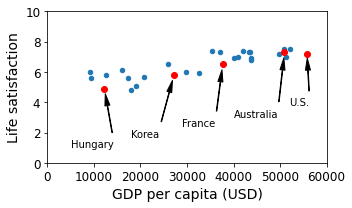

In [16]:
# 7개 국가를 제외한 국가들의 데이터 산점도
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])

# 언급된 5개 국가명 명기 좌표
position_text = {
    "Hungary": (5000, 1),
    "Korea": (18000, 1.7),
    "France": (29000, 2.4),
    "Australia": (40000, 3.0),
    "United States": (52000, 3.8),
}

# 5개 국가는 좌표를 이용하여 빨강색 점으로 표기
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    # 5개 국가명 표기
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    # 5개 국가 산점도 그리기
    plt.plot(pos_data_x, pos_data_y, "ro")
plt.xlabel("GDP per capita (USD)")
save_fig('money_happy_scatterplot')
plt.show()

언급된 5개 국가의 1인당 GDP와 삶의 만족도를 데이터에서 직접 확인하면 다음과 같다.

In [17]:
sample_data.loc[list(position_text.keys())]

,GDP per capita,Life satisfaction
Country,,
Hungary,12239.894,4.9
Korea,27195.197,5.8
France,37675.006,6.5
Australia,50961.865,7.3
United States,55805.204,7.2


### 선형 관계

위 산점도에 따르면 1인당 GDP와 삶의 만족도가 어느 정도 선형 관계에 있는 것처럼 보인다.
아래 도표에서 그려진 세 개의 직선 중에서 파랑색 실선이 선형 관계를 가장 적절하게 나타낸다.

Saving figure tweaking_model_params_plot


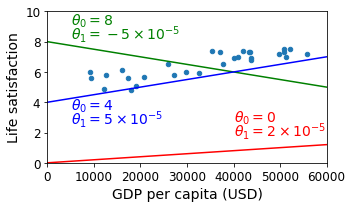

In [18]:
import numpy as np

sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
plt.plot(X, 4 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")
save_fig('tweaking_model_params_plot')
plt.show()

### &#x1f511;  선형회귀 모델 훈련

선형 관계는 위 도표에서처럼 직선으로 구현되는 __선형회귀 모델__(linear regression model)은 
직선의 절편(Y축과 만나는 점)과 기울기 두 개의 __모델 파라미터__(model parameters)에 의해 결정된다.
예를 들어, 1인당 GDP와 삶의 만족도는 아래 선형 모델로 표현할 수 있다.

$$
\text{삶의만족도} = \theta_0 + \theta_1 \times \text{1인당GDP}
$$

아래 코드는 최적의 선형 모델의 절편과 기울기를 알아내는 모델의 생성과 훈련과정을 나타낸다.

* 모델 지정: 사이킷런(sklearn) 패키지의 `linear_model` 모듈에 포함된 `LinearRegression` 클래스 활용
* 훈련 데이터넷 지정
    * 특성 데이터: 1인당 GDP
    * 타깃 데이터: 삶의 만족도
* 모델 훈련: `fit()` 메서드 호출
    * 반환값: 훈련된 선형회귀 모델

In [19]:
from sklearn import linear_model

# 선형회귀 모델 지정
lin1 = linear_model.LinearRegression()

# 훈련 데이터셋 지정
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]

# 모델 훈련
lin1.fit(Xsample, ysample)

LinearRegression()

훈련된 모델이 알아낸 최적 선형 모델의 절편과 기울기는 아래 두 속성에 저장된다.

* `intercept_[0]`: 직선의 절편
* `coef_[0]`: 직선의 기울기

In [20]:
# 예측된 최적의 직선에 대한 정보: 절편과 기울기
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]

t0, t1

(4.853052800266436, 4.911544589158483e-05)

구해진 기울기와 절편을 이용하여 산점도와 함께 직선을 그리면 다음과 같다.

Saving figure best_fit_model_plot


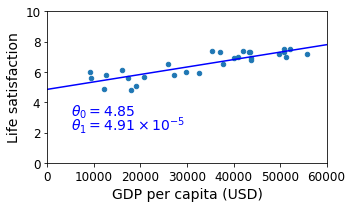

In [21]:
# 산점도
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])

# 직선 그리기
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
# 직선의 절편과 기울기 정보 명시
plt.text(5000, 3.1, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")

save_fig('best_fit_model_plot')
plt.show()


### &#x1f511;  훈련된 모델 활용

훈련된 모델을 이용하여 한 국가의 삶의 만족도를 1인당 GDP를 이용하여 예측한다. 
예를 들어, 키프러스(Cyprus) 1인당 GDP만 다음과 같이 알려져 있을 때 키프러스 국민의 삶의 만족도를 예측한다.

* 키프러스 1인당 GDP: 22587

In [22]:
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita"]
print(cyprus_gdp_per_capita)

22587.49


훈련된 모델의 `predict()` 메서드를 이용하면 키프러스 국민의 삶의 만족도는 5.96 정도로 예측된다.

In [23]:
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0][0]
cyprus_predicted_life_satisfaction

5.96244744318815

아래 도표에서 확인할 수 있듯이 예측값은 정확하게 앞서 확인한 최적의 직선 위에 위치한다.

Saving figure cyprus_prediction_plot


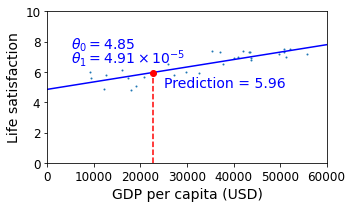

In [24]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3), s=1)
plt.xlabel("GDP per capita (USD)")

# 예측된 최적의 직선
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.axis([0, 60000, 0, 10])
plt.text(5000, 7.5, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 6.6, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")

# 키프러스에 대한 삶의 만족도 예측값

# 빨간 점선 그리기
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(25000, 5.0, r"Prediction = 5.96", fontsize=14, color="b")

# 예측 지점 좌표 찍기(빨강생)
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")
save_fig('cyprus_prediction_plot')
plt.show()

## 머신러닝의 주요 도전 과제

### 대표성 없는 훈련 데이터

앞서 7개 국가의 데이터를 훈련에서 제외시킨 후에 선형회귀 모델을 훈련시켰다.
이제 7개 국가를 포함해서 훈련시켜 보자.
제외된 7개 국가의 데이터는 다음과 같다.

* 브라질(Brazil)
* 멕시코(Mexico)
* 칠레(Chile)
* 체코(Czech Repulic)
* 노르웨이(Norway)
* 스위스(Switzerland)
* 룩셈부르크(Luxembourg)

In [25]:
missing_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


아래 좌표는 7개 국가명을 아래 도표에서 표기할 때 사용할 좌표이다.

In [26]:
position_text2 = {
    "Brazil": (1000, 9.0),
    "Mexico": (11000, 9.0),
    "Chile": (25000, 9.0),
    "Czech Republic": (35000, 9.0),
    "Norway": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

7개 국가를 포함한 전체 훈련 데이터셋을 이용하여 훈련한 결과를
7개 국가를 제외했을 때의 훈련 결과와 비교한다.

* 검정 실선: 7개 국가 포함 예측 선형 모델
* 파랑 점선: 7개 국가 제외 예측 선형 모델

__결론:__ 선형회귀 모델은 1인당 GDP와 삶의 만족도 사이의 관계를 모델링 하기에 부적합하다.

Saving figure representative_training_data_scatterplot


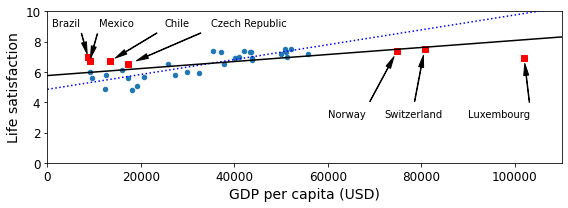

In [27]:
# 7개 국가를 제외한 국가들의 산점도 (파랑색 점)
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

# 7개 국가 산점도(빨강 점)
for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    # 7개 국가명 표기
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

# 7개 국가 제외 예측 선형 모델 그래프 (파랑 점선)
X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b:")

# 7개 국가 포함 선형회귀 모델 훈련 및 예측
lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

# 7개 국가 포함 예측 선형 모델 그래프(검정 실선)
t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.xlabel("GDP per capita (USD)")

save_fig('representative_training_data_scatterplot')
plt.show()

### 과대적합과 모델 규제

#### 과대적합

훈련된 모델이 훈련데이터에는 너무나도 잘 맞지만 새로운 데이터에 대해서는 잘 작동하지 않을 때 해당 모델이 훈련데이터에 __과대적합__되었다고 말한다.

예를 들어, 
아래 코드는 4장에서 다룰 고차항 다항회귀를 이용하여 선형이 아니라 60차 다항식의 그래프로 모델을 예측한다.
결과는 훈련데이터셋에 매우 잘 들어맞지만, 새루운 데이터에 대해 훈련된 모델이 제대로된 예측을 할 수 있을 
거라고 믿기는 어렵다. 이런 모델은 __일반화가 어렵다__라고 말한다.

__주의사항:__ 아래 코드를 지금 당장 이해하려고 시도할 필요는 없다.

/Users/gslee/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/gslee/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Saving figure overfitting_model_plot


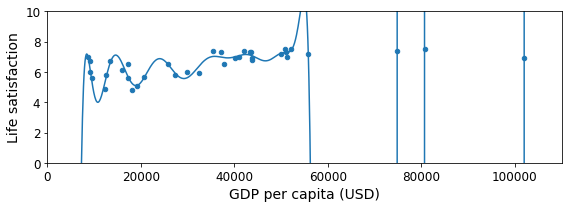

In [28]:
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=60, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
plt.xlabel("GDP per capita (USD)")
save_fig('overfitting_model_plot')
plt.show()

훈련세트에 잡음이 많이 있거나 데이터셋이 너무 작으면 훈련 과정에서 별로 상관 없는 특성을 이용하려고 시도할 수도 있다. 
예를 들어, 아래 코드에서 확인할 수 있듯이 OECD에 속하는 국가 중에서 나라 이름에 영어 알파벳 W가 포함된 아래의 나라의 삶의 만족도가 매우 높은 편이다. 

In [29]:
full_country_stats.loc[[c for c in full_country_stats.index if "W" in c.upper()]]["Life satisfaction"]

Country
New Zealand    7.3
Sweden         7.2
Norway         7.4
Switzerland    7.5
Name: Life satisfaction, dtype: float64

하지만 그렇다해서 나라명에 영어 알파벳 W가 포함된 모든 나라의 삶의 만족도가 높다고 결론 지을 수는 없다.
실제로 영어 알파벳 W를 포함한 국가 중에 여러 국가의 1인당 GDP가 아래 코드에서 볼 수 있듯이 매우 낮은데,
예를 들어, 루완다(Rwanda), 짐바브웨(Zimbabwe) 등의 국가의 삶의 만족도를 그럼에도 불구하고 매우 높다고 말할 수는 없다.

In [30]:
gdp_per_capita.loc[[c for c in gdp_per_capita.index if "W" in c.upper()]].head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Botswana,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",6040.957,2008.0
Kuwait,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",29363.027,2014.0
Malawi,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",354.275,2011.0
New Zealand,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",37044.891,2015.0
Norway,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",74822.106,2015.0


#### 모델 규제

4장에서 다루는 '규제가 있는 선형 모델'에서 다루는 이용하면 과대적합의 위험을 줄일 수 있다.
이렇게 과대적합의 위험을 감소시키기 위에 훈련 모델에 제약을 가하는 것을 __규제__(regularization)라고 한다.

아래 코드는 세 개의 모델을 비교한다.

* 빨강 파선: 7개 국가 포함 예측 선형 모델
* 파랑 점선: 7개 국가 제외 예측 선형 모델
* 파랑 실선: 7개 국가 제외 규제 적용 예측 선형 모델
    * 규제 방식: Ridge 규제(4장 참조)

7개 국가를 제외하더라도 모델에 규제를 적용하면 데이터에 덜 과대적합한 모델을 얻게 됨을 
세 개의 그래프를 비교해서 알 수 있다.

Saving figure ridge_model_plot


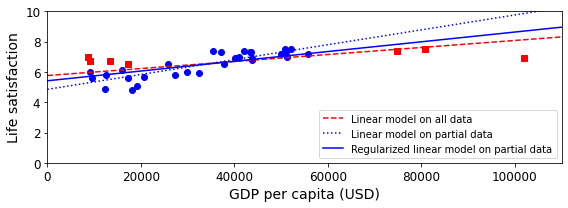

In [31]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

# 7개 국가 제외 데이터 산점도(파랑 동그라미)
plt.plot(list(sample_data["GDP per capita"]), list(sample_data["Life satisfaction"]), "bo")
# 제외된 7개 국가 산점도(빨강 네모)
plt.plot(list(missing_data["GDP per capita"]), list(missing_data["Life satisfaction"]), "rs")

# 7개 국가 포함 예측 선형 모델 그래프(빨강 파선)
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
# 7개 국가 제외 예측 선형 모델 그래프(파랑 점선)
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

# 릿지(Ridge) 규제 적용 훈련: 7개 국가 제외 데이터 대상
ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample, ysample)
# 릿지 규제 적용 예측 선형 모델 그래프(파랑 실선)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 110000, 0, 10])
plt.xlabel("GDP per capita (USD)")
save_fig('ridge_model_plot')
plt.show()

## 사례 기반 학습

키프러스의 삶의 만족도를 사례 기반 학습으로 예측하기 위해
1인당 GDP가 키프러스의 경우가 가장 가까운 국가들의 삶의 만족도의 평균값을 활용할 수 있다.

예를 들어, 키프러스의 1인당 GDP와 가장 가까운 세 나라는 다음과 같다.

* 포루투갈(Portugal)
* 슬로베니아(Slovenia)
* 스페인(Spain)

In [32]:
sample_data[7:10]

,GDP per capita,Life satisfaction
Country,,
Portugal,19121.592,5.1
Slovenia,20732.482,5.7
Spain,25864.721,6.5


위 세 나라의 삶의 만족도의 평균값은 다음과 같다.

In [33]:
(5.1 + 5.7 + 6.5)/3

5.766666666666667

앞서 설명한 알고리즘을 __k-최근접 이웃__ 회귀라고 하며,
위 예제에서 사용된 k는 3이다. 

사이킷런에서 지원하는 k-최근접 이웃 회귀모델을 적용하면 동일한 결과를 얻게 된다.

* `n_neighbors = 3`: 예측할 데이터와 가장 가까운 3개의 훈련 데이터 정보를 활용한다는 의미임.

In [34]:
import sklearn.neighbors
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

In [35]:
X = np.c_[sample_data["GDP per capita"]]
y = np.c_[sample_data["Life satisfaction"]]

# 모델 훈련
model.fit(X, y)

# 키프러스 국가에 대한 예측하기
X_new = np.array([[22587.0]])  # Cyprus' GDP per capita
print(model.predict(X_new)) # outputs [[ 5.76666667]]

[[5.76666667]]


## 연습문제

1. OECD 삶의 만족도 데이터와 IMF 1인당 GDP 데이터를 2020년 기준으로 업데이트하여 앞서 살펴본 과정과 동일한 과정을 수행하라.
    2020년 기준 데이터는 아래 정보를 사용한다.
    
    * 기본 다운로드 경로
    
    ```python
    DOWNLOAD_ROOT = "https://raw.githubusercontent.com/codingalzi/handson-ml/master/"
    ```
    
    * BLI 데이터 파일명: oecd_bli_2020.csv
    * 1인당 GDP 데이터: gdp_per_capita_2020.xlsx
    
    주의사항:

    * 1인당 GDP 데이터는 엑셀 파일로 주어졌다. 팬다스의 `read_csv()` 대신에 `read_excel()` 파일을 사용한다.
    * `rename()` 메서드를 활용할 때 '2020' 문자열 대신에 2020 정수를 사용해야 한다.
    * 제외되는 7개 국가 정보는 다음과 같다.
        * 제외 국가 인덱스

        ```python
        remove_indices = [1, 2, 4, 6, 37, 38, 39]
        keep_indices = list(set(range(40)) - set(remove_indices))
        ```
        
        * 제외 국가: Columbia(콜롬비아), Brazil(브라질), Mexico(멕시코), Chille(칠레), 
            Ireland(아일랜드), Switzerland(스위스, Luxembourg(룩셈부르크)
        
    * 언급된 5개 국가명 명기 좌표

    ```python
    position_text = {
        "Hungary": (8000, 1),
        "Korea": (26000, 1.7),
        "France": (34000, 2.4),
        "Australia": (44000, 3.0),
        "United States": (60000, 3.8),
    }
    ```